## _*H2 excited states from ExactEigensolver*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state and excited state energies of the Hydrogen (H2) molecule over a range of inter-atomic distances. This notebook utilizes the fact that when two_qubit_reduction is used with the parity mapping on H2 the resultant hamiltionian solely contains the 4 states we are looking for.

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the Qiskit Chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; H .0 .0 {0}'

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies  = np.empty([4, steps+1])
distances = np.empty(steps+1)

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True)
    qubit_op, aux_ops = operator.run(qmolecule)
    result = ExactEigensolver(qubit_op, k=4).run()
    lines, result = operator.process_algorithm_result(result)
    result['printable'] = lines

    energies[:, i] = result['energies']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)

Couldn't find cython int routine
Couldn't find cython int routine
Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]
 [-0.07074011 -0.13940618 -0.20191839 -0.25891828 -0.31096009 -0.35852853
  -0.402052   -0.44191252 -0.47845306 -0.51198296 -0.5427821  -0.57110389
  -0.5971778  -0.62121128 -0.64339155 -0.66388713 -0.68284939 -0.70041397
  -0.71670221 -0.73182253 -0.74587179]
 [ 0.26700034  0.20067908  0.14057064  0.08603034  0.0365012  -0.00850382
  -0.0494151  -0.08661632 -0.1204519  -0.15123247 -0.17923903 -0.2047261
  -0.22792423 -0.24904202 -0.26826785 -0.28577159 -0.301706   -0.31620832
  -0.329

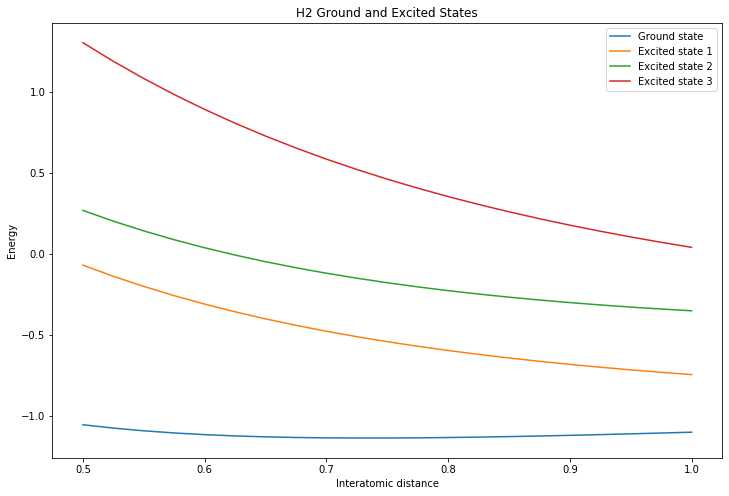

In [2]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(energies.shape[0]):
    label = 'Ground state' if j ==0 else 'Excited state {}'.format(j)
    pylab.plot(distances, energies[j], label=label)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground and Excited States')
pylab.legend(loc='upper right')
pylab.show()

The above plot has all the states. Below we plot them individually. With each plot having its own y-axis scale the energy change over distance change is more evident, particularly the ground state curve which is very flattened above by the scale.

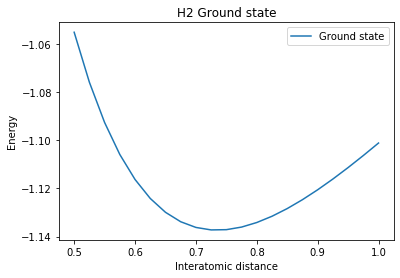

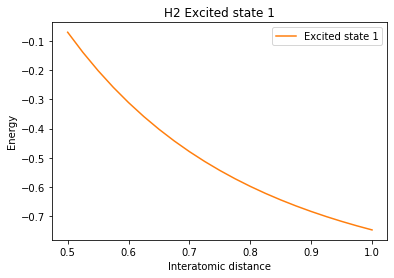

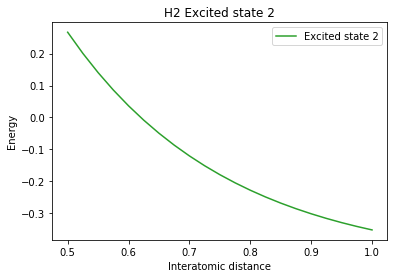

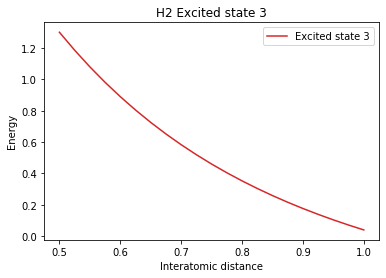

In [3]:
pylab.rcParams['figure.figsize'] = (6, 4)
prop_cycle = pylab.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for j in range(energies.shape[0]):
    label = 'Ground state' if j ==0 else 'Excited state {}'.format(j)
    pylab.plot(distances, energies[j], color=colors[j], label=label)
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.title('H2 {}'.format(label))
    pylab.legend(loc='upper right')
    pylab.show()